In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyproj import CRS
from scipy.spatial import cKDTree

# Local application/library specific imports
import importlib
import project_functions as pf

# Reloading the local module 
importlib.reload(pf)

# Base path
base_path = 'C:/Users/lissn/Thesis'

### Load data

In [2]:
# Load 2023 SVK data
SVK_path22 = base_path + '/data/2022_rain_observations.csv'
df22 = pd.read_csv(SVK_path22)
df22['time'] = pd.to_datetime(df22['time'])
df22= df22[df22['time'].dt.year == 2022] # Only keep 2022 data

# Load 2023 SVK data
SVK_path23 = base_path + '/data/2023_rain_observations.csv'
df23 = pd.read_csv(SVK_path23)
df23['time'] = pd.to_datetime(df23['time'])
df23= df23[df23['time'].dt.year == 2023] # Only keep 2023 data

# Concatenate the two dataframes
df = pd.concat([df22, df23], ignore_index=True)
df = df.set_index(df.columns[0])

In [3]:
# Load radar meta data
radar_path = base_path + '/data/meta_data/radar_meta_data.csv' 
radar_df = pd.read_csv(radar_path)

# Load gague station meta data
station_path = base_path + '/data/meta_data/SVK_stationsliste.txt' 
station_df = pd.read_csv(station_path,  sep=' ', index_col=False)
station_df.rename(columns={'05Nr': 'stationId'}, inplace=True)
station_df = station_df[station_df['Slutdato'].isna()] # Only keep active stations
station_df = station_df[['stationId', 'Stationsnavn', 'Northings', 'Eastings' ]] # Only keep relevant columns

In [4]:
# Correct mistake in SVK data
station_df['Northings'] = station_df['Northings'].apply(lambda x: x / 1e8 if x > 1e9 else x)
station_df['Eastings'] = station_df['Eastings'].apply(lambda x: x / 1e9 if x > 1e9 else x)

# Apply transformation (from northings/eastings to lat/lon)
station_df['Longitude'], station_df['Latitude'] = zip(*station_df.apply(lambda row: pf.transform_coordinates_from_EUREF89_to_WGS84(row['Eastings'], row['Northings']), axis=1))

# Filter such that only stations with measured data are included
station_df['stationId_str'] = station_df['stationId'].astype(str)
station_df = station_df[station_df['stationId_str'].isin(df.columns)]

In [5]:
# Mark gauges than is located in the cone of silence (25 km from radar)
vec_haversine = np.vectorize(pf.haversine) # Vectorize the haversine function 
station_df['Within_25km_of_Radar'] = False # Initialize a column with False indicating no radar within 25 km

for index, station in station_df.iterrows():
    # Calculate distances to all radars
    distances = vec_haversine(station['Longitude'], station['Latitude'],
                              radar_df['Longitude'].values, radar_df['Latitude'].values)
    
    # Check if any distance is less than 25 km
    if np.any(distances < 25):
        # Update the column for this station
        station_df.at[index, 'Within_25km_of_Radar'] = True

In [6]:
# Get radar coordinate grid with longitudes and latitudes
x_radar_coords = np.arange(-421364.8 - 500, 569635.2 + 500, 500) 
y_radar_coords = np.arange(468631 + 500, -394369 - 500, -500)
dmi_stere_crs = CRS("+proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56") # raw data CRS projection
plotting_crs = 'epsg:4326' # the CRS projection you want to plot the data in
radar_lons, radar_lats = pf.transform_raster_grid_coordinates(x_radar_coords, y_radar_coords, dmi_stere_crs, plotting_crs) 

In [7]:
# Calculate midpoints for longitude and latitude separately
mid_lons = pf.calculate_midpoints(radar_lons)
mid_lats = pf. calculate_midpoints(radar_lats)

# Prepare the radar points (midpoints of pixels) for KDTree
radar_midpoints = np.column_stack((mid_lons.flatten(), mid_lats.flatten()))

# Build a KDTree for fast nearest-neighbor lookup using radar midpoints
tree = cKDTree(radar_midpoints)

# Convert station locations to an array of (longitude, latitude) pairs for searching
station_points = station_df[['Longitude', 'Latitude']].values

# Find the nearest radar pixel midpoint for each station
distances, indices_1d = tree.query(station_points)

# Translate the 1D indices back to 2D indices in the radar arrays
# Note: We subtract 1 from the shape of the radar arrays because the midpoints grid is smaller
num_cols = radar_lons.shape[1] - 1
indices_row = indices_1d // num_cols
indices_col = indices_1d % num_cols

# Add the indices to station_df
station_df['radar_pixel_row'] = indices_row
station_df['radar_pixel_col'] = indices_col

### Train/test split

In [8]:
importlib.reload(pf)
# Split data into test and train set using K-means clustering for geographical spread of test stations
df_clean = station_df[station_df['Within_25km_of_Radar'] == False] # Remove stations within 25 km of radar
train_station_ids, val_station_ids, test_station_ids = pf.split_train_val_test_using_Kmeans(df_clean, n_clusters = 10)

print("Total number of stations:", len(station_df))
print('Number of excluded stations in cone of silence:', len(station_df[station_df['Within_25km_of_Radar'] == True]))
print('Number of train guages:', len(train_station_ids))
print('Number of validation guages:', len(val_station_ids))
print('Number of test guages:', len(test_station_ids))

print('Train stations:', train_station_ids)
print('Validation stations:', val_station_ids)
print('Test stations:', test_station_ids)

Total number of stations: 191
Number of excluded stations in cone of silence: 19
Number of train guages: 140
Number of validation guages: 16
Number of test guages: 16
Train stations: [5045, 5047, 5052, 5054, 5056, 5058, 5061, 5107, 5115, 5125, 5273, 5279, 5281, 5283, 5285, 5122, 5123, 5124, 5130, 5145, 5180, 5190, 5192, 5201, 5207, 5282, 5155, 5479, 5485, 5509, 5521, 5230, 5232, 5235, 5239, 5240, 5243, 5245, 5248, 5251, 5252, 5255, 5260, 5265, 5340, 5359, 5363, 5370, 5377, 5397, 5403, 5404, 5409, 5411, 5412, 5413, 5414, 5415, 5418, 5419, 5425, 5427, 5429, 5459, 5461, 5465, 5540, 5590, 5593, 5815, 5824, 5825, 5830, 5840, 5845, 5849, 5855, 5859, 5865, 5870, 5555, 5560, 5565, 5570, 5572, 5576, 5577, 5578, 5579, 5580, 5581, 5585, 5596, 5600, 5607, 5610, 5618, 5620, 5602, 5623, 5625, 5633, 5641, 5643, 5645, 5647, 5655, 5660, 5665, 5675, 5685, 5690, 5694, 5697, 5698, 5699, 5705, 5710, 5725, 5730, 5731, 5732, 5733, 5740, 5750, 5755, 5759, 5763, 5771, 5775, 5781, 5790, 5795, 5800, 5805, 5901, 

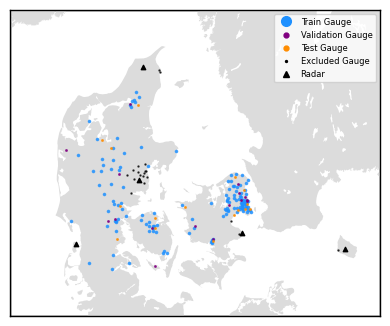

In [9]:
# Plot train/test/excluded gagues
save_path = 'C:/Users/lissn/Thesis/figures/Train_Test_Station_Map.png'
importlib.reload(pf)
pf.plot_test_train_val_split(station_df, radar_df, test_station_ids, val_station_ids, save_path=save_path)

### Generate data for model type 1

In [60]:
def generate_ZR_data(station_ids, df, station_df, data_dir, start_date, end_date):

    samples = []
    start_date_dt, end_date_dt = pd.to_datetime(start_date), pd.to_datetime(end_date)
    filtered_dates = df.index[(df.index >= start_date_dt) & (df.index <= end_date_dt)]

    for date in tqdm(filtered_dates):
        year, month, day, hour, minute = date.year, date.month, date.day, date.hour, date.minute
        file_path = f"{data_dir}/{year}/{year}/{month:02d}/{day:02d}/dk.com.{year}{month:02d}{day:02d}{hour:02d}{minute:02d}.500_max.h5"
        radar_image, success = pf.load_radar_image(file_path) 
        if not success:
            continue

        for station_ID in station_ids:
            rain_gauge_value = df.loc[date, str(station_ID)]
            filtered_df = station_df[station_df['stationId'] == station_ID]
            r_idx, c_idx = filtered_df['radar_pixel_row'].iloc[0], filtered_df['radar_pixel_col'].iloc[0]
            dBZ = pf.raw_radar_data_to_dbz(radar_image[r_idx, c_idx])
            Z = pf.dbz_to_Z(dBZ)

            sample_dict = {
                'timestamp': date, 'stationId': station_ID, 'R': rain_gauge_value, 'Z': Z[0]}
            samples.append(sample_dict)
        
    return pd.DataFrame(samples)



In [27]:
data_dir =  f"C:/Users/lissn/Thesis/data/radar"
# Generate ZR data
#test_samples_df = generate_ZR_data(test_station_ids, df, station_df, data_dir, start_date='20230402', end_date='20231231')
#train_samples_df = generate_ZR_data(train_station_ids, df, station_df, data_dir, start_date='2022-04-02', end_date='2023-04-01')

# Save samples as csv
#test_samples_df.to_csv('C:/Users/lissn/Thesis/data/testZR.csv', index=False)
#train_samples_df.to_csv('C:/Users/lissn/Thesis/data/trainZR.csv', index=False)

In [11]:
df = pd.read_csv('C:/Users/lissn/Thesis/data/trainZR.csv')
train_samples_df = df[(df['R'] != 0) & (df['Z'] != 0) & ~df['R'].isnull() & ~df['Z'].isnull()]
print('Number of train samples:', train_samples_df.shape)

df = pd.read_csv('C:/Users/lissn/Thesis/data/testZR.csv')
test_samples_df = df[(df['R'] != 0) & (df['Z'] != 0) & ~df['R'].isnull() & ~df['Z'].isnull()]
print('Number of test samples:', test_samples_df.shape)

Number of train samples: (734991, 4)
Number of test samples: (40483, 4)


### Generate data for model type 2

In [61]:
def toy(date_input):
    days_in_year = 365.25  # Average to account for leap years
    date = pd.to_datetime(date_input)
    day_of_year = date.day_of_year
    sin_time_of_year = np.sin(2 * np.pi * day_of_year / days_in_year)
    cos_time_of_year = np.cos(2 * np.pi * day_of_year / days_in_year)
    return sin_time_of_year, cos_time_of_year

def tod(time_input):
    time = pd.to_datetime(time_input)
    seconds_since_midnight = (time - time.normalize()).seconds
    seconds_in_a_day = 24 * 60 * 60
    fraction_of_day = seconds_since_midnight / seconds_in_a_day
    sin_time_of_day = np.sin(2 * np.pi * fraction_of_day)
    cos_time_of_day = np.cos(2 * np.pi * fraction_of_day)
    return sin_time_of_day, cos_time_of_day

def generate_ZR_data_with_features(station_ids, df, station_df, data_dir, start_date, end_date, dist_coast, dist_radar, topo):

    samples = []
    start_date_dt, end_date_dt = pd.to_datetime(start_date), pd.to_datetime(end_date)
    filtered_dates = df.index[(df.index >= start_date_dt) & (df.index <= end_date_dt)]

    for date in tqdm(filtered_dates):
        year, month, day, hour, minute = date.year, date.month, date.day, date.hour, date.minute
        file_path = f"{data_dir}/{year}/{year}/{month:02d}/{day:02d}/dk.com.{year}{month:02d}{day:02d}{hour:02d}{minute:02d}.500_max.h5"
        radar_image, success = pf.load_radar_image(file_path) 
        if not success:
            continue

        for station_ID in station_ids:
            rain_gauge_value = df.loc[date, str(station_ID)]
            filtered_df = station_df[station_df['stationId'] == station_ID]
            r_idx, c_idx = filtered_df['radar_pixel_row'].iloc[0], filtered_df['radar_pixel_col'].iloc[0]
            dBZ = pf.raw_radar_data_to_dbz(radar_image[r_idx, c_idx])
            Z = pf.dbz_to_Z(dBZ)

            sin_toy, cos_toy = toy(date)
            sin_tod, cos_tod = tod(date)
            sample_dict = {
                'timestamp': date, 
                'stationId': station_ID, 
                'R': rain_gauge_value, 
                'Z': Z[0],
                'dBZ': dBZ[0],
                'radar_norm': radar_image[r_idx, c_idx]/255.0,
                'dist_coast': dist_coast[r_idx, c_idx],
                'dist_radar': dist_radar[r_idx, c_idx],
                'topo': topo[r_idx, c_idx],
                'toy_sin': sin_toy,
                'toy_cos': cos_toy,
                'tod_sin': sin_tod,
                'tod_cos': cos_tod}
            
            samples.append(sample_dict)
        
    return pd.DataFrame(samples)

In [62]:
# Load features
dist_coast = np.load('dist_coast_01.npy')
dist_radar = np.load('dist_radar_01.npy')
topo = np.load('topo_01.npy') 

# Normalize with Min-Max Scaling to [0, 1]
def min_max_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

dist_coast = min_max_normalize(dist_coast)
dist_radar = min_max_normalize(dist_radar)
topo= min_max_normalize(topo)

100%|██████████| 104833/104833 [3:21:22<00:00,  8.68it/s]   


In [ ]:
# Generate ZR2 data
#train_samples_df = generate_ZR_data_with_features(train_station_ids, df, station_df, data_dir, start_date='20220402', end_date='20230401', dist_coast=dist_coast, dist_radar=dist_radar, topo=topo)

In [63]:
#train_samples_df.to_csv('C:/Users/lissn/Thesis/data/trainZR_v2.csv', index=False)

In [65]:
val_samples_df = generate_ZR_data_with_features(val_station_ids, df, station_df, data_dir, start_date='20230402', end_date='20231231', dist_coast=dist_coast, dist_radar=dist_radar, topo=topo)
test_samples_df = generate_ZR_data_with_features(test_station_ids, df, station_df, data_dir, start_date='20230402', end_date='20231231', dist_coast=dist_coast, dist_radar=dist_radar, topo=topo)

100%|██████████| 78625/78625 [46:03<00:00, 28.45it/s]  


In [66]:
val_samples_df.to_csv('C:/Users/lissn/Thesis/data/valZR_v2.csv', index=False)
test_samples_df.to_csv('C:/Users/lissn/Thesis/data/testZR_v2.csv', index=False)

In [72]:
train_samples_df.head(20)

,timestamp,stationId,R,Z,dBZ,radar_norm,dist_coast,dist_radar,topo,toy_sin,toy_cos,tod_sin,tod_cos
0,2022-04-02 04:10:00,5045,0.0,0.0,0.0,0.0,0.004757,0.069321,0.085714,0.99993,-0.011826,0.887011,0.461749
1,2022-04-02 04:10:00,5047,0.0,0.0,0.0,0.0,0.039805,0.057762,0.114286,0.99993,-0.011826,0.887011,0.461749
2,2022-04-02 04:10:00,5052,0.0,0.0,0.0,0.0,0.000440,0.079317,0.057143,0.99993,-0.011826,0.887011,0.461749
3,2022-04-02 04:10:00,5054,0.0,0.0,0.0,0.0,0.000815,0.077850,0.142857,0.99993,-0.011826,0.887011,0.461749
4,2022-04-02 04:10:00,5056,0.0,0.0,0.0,0.0,0.000000,0.081571,0.057143,0.99993,-0.011826,0.887011,0.461749
5,2022-04-02 04:10:00,5058,0.0,0.0,0.0,0.0,0.017037,0.090636,0.342857,0.99993,-0.011826,0.887011,0.461749
6,2022-04-02 04:10:00,5061,0.0,0.0,0.0,0.0,0.027311,0.094591,0.171429,0.99993,-0.011826,0.887011,0.461749
7,2022-04-02 04:10:00,5107,0.0,0.0,0.0,0.0,0.005579,0.173747,0.085714,0.99993,-0.011826,0.887011,0.461749
8,2022-04-02 04:10:00,5115,0.0,0.0,0.0,0.0,0.004619,0.135873,0.057143,0.99993,-0.011826,0.887011,0.461749
9,2022-04-02 04:10:00,5125,0.0,0.0,0.0,0.0,0.104482,0.100079,0.257143,0.99993,-0.011826,0.887011,0.461749


### For spatial test data

In [18]:
dist_coast.shape

(1729, 1985)

In [8]:
from datetime import datetime
importlib.reload(pf)

data_dir =  f"C:/Users/lissn/Thesis/data/radar"
year = '2023'
month = '10'
day = '03'
hour = '02'
minute = '00'

# Combine the components into a single datetime string
datetime_str = f"{year}-{month}-{day} {hour}:{minute}"
date = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')

file_path = f"{data_dir}/{year}/{year}/{month}/{day}/dk.com.{year}{month}{day}{hour}{minute}.500_max.h5"
radar_image, success = pf.load_radar_image(file_path) 

dBZ = pf.raw_radar_data_to_dbz(radar_image)
Z = pf.dbz_to_Z(dBZ)

sin_toy, cos_toy = pf.toy(date)
sin_tod, cos_tod = pf.tod(date)

# Load features
dist_coast = np.load('climate.npy')
dist_radar = np.load('dist_radar_01.npy')
topo = np.load('topo_01.npy')
is_land_mask = np.load('is_land_grid.npy') * topo > 0

# Normalize with Min-Max Scaling to [0, 1]
def min_max_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

dist_coast = min_max_normalize(dist_coast)
dist_radar = min_max_normalize(dist_radar)
topo= min_max_normalize(topo)

samples = []

for row in range(radar_image.shape[0]):
    for col in range(radar_image.shape[1]):
        if is_land_mask[row, col]:
            sample_dict = {
                'row': row,
                'col': col,
                'timestamp': date, 
                'stationId': None, 
                'R': None, 
                'Z': Z[row, col],
                'dBZ': dBZ[row, col],
                'radar_norm': radar_image[row, col]/255.0,
                'dist_coast': dist_coast[row, col],
                'dist_radar': dist_radar[row, col],
                'topo': topo[row, col],
                'toy_sin': sin_toy,
                'toy_cos': cos_toy,
                'tod_sin': sin_tod,
                'tod_cos': cos_tod}
            
            samples.append(sample_dict)

df = pd.DataFrame(samples)
df.head()

,row,col,timestamp,stationId,R,Z,dBZ,radar_norm,dist_coast,dist_radar,topo,toy_sin,toy_cos,tod_sin,tod_cos
0,549,845,2023-10-03 02:00:00,None,None,31.622777,15.0,0.368627,4.440892e-19,0.061749,0.085714,-0.999371,0.035473,0.5,0.866025
1,549,846,2023-10-03 02:00:00,None,None,25.118864,14.0,0.360784,4.440892e-19,0.062289,0.057143,-0.999371,0.035473,0.5,0.866025
2,549,847,2023-10-03 02:00:00,None,None,50.118723,17.0,0.384314,4.440892e-19,0.062834,0.085714,-0.999371,0.035473,0.5,0.866025
3,549,848,2023-10-03 02:00:00,None,None,25.118864,14.0,0.360784,4.440892e-19,0.063385,0.085714,-0.999371,0.035473,0.5,0.866025
4,549,849,2023-10-03 02:00:00,None,None,79.432823,19.0,0.400000,4.440892e-19,0.063940,0.085714,-0.999371,0.035473,0.5,0.866025


In [14]:
df.to_csv('C:/Users/lissn/Thesis/data/test_spatial.csv', index=False)

### Spatial test data 2

In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import importlib

# Reload the module if needed
importlib.reload(pf)

data_dir = "C:/Users/lissn/Thesis/data/radar"
year = "2023"  
month = "10"   
day = "03"     
hour = "02"  
minute = "00"   

# Combine the components into a single datetime string
datetime_str = f"{year}-{month}-{day} {hour}:{minute}"
date = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')

# Function to load radar image and convert to dBZ
def load_and_process_radar_image(date, data_dir):
    file_path = f"{data_dir}/{date.year}/{date.year}/{date.month:02d}/{date.day:02d}/dk.com.{date.year}{date.month:02d}{date.day:02d}{date.hour:02d}{date.minute:02d}.500_max.h5"
    radar_image, success = pf.load_radar_image(file_path)
    if success:
        dBZ = pf.raw_radar_data_to_dbz(radar_image)
        Z = pf.dbz_to_Z(dBZ)
        return dBZ, Z, radar_image
    else:
        return None, None

# Load current radar image
dBZ_current, Z_current, radar_image = load_and_process_radar_image(date, data_dir)

# Load radar image from 10 minutes earlier
date_10min_earlier = date - timedelta(minutes=10)
dBZ_earlier, Z_earlier, radar_image = load_and_process_radar_image(date_10min_earlier, data_dir)

# Ensure both images are loaded successfully
if dBZ_current is None or dBZ_earlier is None:
    raise ValueError("Failed to load one or both radar images.")

# Compute the difference in dBZ values
dBZ_difference = (Z_current - Z_earlier)

# Load additional features
dist_coast = np.load('climate.npy')
dist_radar = np.load('dist_radar_01.npy')
topo = np.load('topo_01.npy')
is_land_mask = np.load('is_land_grid.npy') * topo > 0

# Normalize with Min-Max Scaling to [0, 1]
def min_max_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

dist_coast = min_max_normalize(dist_coast)
dist_radar = min_max_normalize(dist_radar)
topo = min_max_normalize(topo)

sin_toy, cos_toy = pf.toy(date)
sin_tod, cos_tod = pf.tod(date)

samples = []

for row in range(dBZ_current.shape[0]):
    for col in range(dBZ_current.shape[1]):
        #if is_land_mask[row, col]:
        sample_dict = {
            'row': row,
            'col': col,
            'timestamp': date, 
            'stationId': None, 
            'R': None, 
            'Z': Z_current[row, col],
            'dBZ': dBZ_current[row, col],
            'dBZ_diff': dBZ_difference[row, col],  # New variable for dBZ difference
            'radar_norm': radar_image[row, col] / 255.0,
            'dist_coast': dist_coast[row, col],
            'dist_radar': dist_radar[row, col],
            'topo': topo[row, col],
            'toy_sin': sin_toy,
            'toy_cos': cos_toy,
            'tod_sin': sin_tod,
            'tod_cos': cos_tod}
        
        samples.append(sample_dict)

df = pd.DataFrame(samples)

# Format the date to use in the filename
date_str = date.strftime('%Y%m%d_%H%M')
output_file_path = f'C:/Users/lissn/Thesis/data/test_spatial_{date_str}.csv'

# Save the DataFrame to a CSV file with the date in the filename
df.to_csv(output_file_path, index=False)

print(f"Data saved to {output_file_path}")


Data saved to C:/Users/lissn/Thesis/data/test_spatial_20231003_0200.csv


: 

In [27]:
df.head()

,row,col,timestamp,stationId,R,Z,dBZ,dBZ_diff,radar_norm,dist_coast,dist_radar,topo,toy_sin,toy_cos,tod_sin,tod_cos
0,549,845,2023-08-25 05:00:00,None,None,398.107171,26.0,347.988447,0.384314,4.440892e-19,0.061749,0.085714,-0.804826,-0.593511,0.965926,0.258819
1,549,846,2023-08-25 05:00:00,None,None,562.341325,27.5,546.492393,0.345098,4.440892e-19,0.062289,0.057143,-0.804826,-0.593511,0.965926,0.258819
2,549,847,2023-08-25 05:00:00,None,None,398.107171,26.0,382.258239,0.345098,4.440892e-19,0.062834,0.085714,-0.804826,-0.593511,0.965926,0.258819
3,549,848,2023-08-25 05:00:00,None,None,630.957344,28.0,616.831969,0.341176,4.440892e-19,0.063385,0.085714,-0.804826,-0.593511,0.965926,0.258819
4,549,849,2023-08-25 05:00:00,None,None,630.957344,28.0,619.737160,0.333333,4.440892e-19,0.063940,0.085714,-0.804826,-0.593511,0.965926,0.258819


# Generate data for model type 3

In [10]:
def toy(date_input):
    days_in_year = 365.25  # Average to account for leap years
    date = pd.to_datetime(date_input)
    day_of_year = date.day_of_year
    sin_time_of_year = np.sin(2 * np.pi * day_of_year / days_in_year)
    cos_time_of_year = np.cos(2 * np.pi * day_of_year / days_in_year)
    return sin_time_of_year, cos_time_of_year

def tod(time_input):
    time = pd.to_datetime(time_input)
    seconds_since_midnight = (time - time.normalize()).seconds
    seconds_in_a_day = 24 * 60 * 60
    fraction_of_day = seconds_since_midnight / seconds_in_a_day
    sin_time_of_day = np.sin(2 * np.pi * fraction_of_day)
    cos_time_of_day = np.cos(2 * np.pi * fraction_of_day)
    return sin_time_of_day, cos_time_of_day

def generate_ZR_data_with_features_and_images(station_ids, df, station_df, data_dir, start_date, end_date, dist_coast, dist_radar, topo):

    samples = []
    start_date_dt, end_date_dt = pd.to_datetime(start_date), pd.to_datetime(end_date)
    filtered_dates = df.index[(df.index >= start_date_dt) & (df.index <= end_date_dt)]

    for date in tqdm(filtered_dates):
        year, month, day, hour, minute = date.year, date.month, date.day, date.hour, date.minute
        file_path = f"{data_dir}/{year}/{year}/{month:02d}/{day:02d}/dk.com.{year}{month:02d}{day:02d}{hour:02d}{minute:02d}.500_max.h5"
        radar_image, success = pf.load_radar_image(file_path) 
        if not success:
            continue

        for station_ID in station_ids:
            rain_gauge_value = df.loc[date, str(station_ID)]
            filtered_df = station_df[station_df['stationId'] == station_ID]
            r_idx, c_idx = filtered_df['radar_pixel_row'].iloc[0], filtered_df['radar_pixel_col'].iloc[0]
            dBZ = pf.raw_radar_data_to_dbz(radar_image[r_idx, c_idx])
            Z = pf.dbz_to_Z(dBZ)

            x_min, x_max, y_min, y_max, cropped_radar_image = pf.crop_image(radar_image, r_idx, c_idx, crop_size = 63) 
            cropped_radar_image /= 255.0
            
            sin_toy, cos_toy = toy(date)
            sin_tod, cos_tod = tod(date)
            sample_dict = {
                'timestamp': date, 
                'stationId': station_ID, 
                'R': rain_gauge_value, 
                'Z': Z[0],
                'dBZ': dBZ[0],
                'radar_norm': radar_image[r_idx, c_idx]/255.0,
                'dist_coast': dist_coast[r_idx, c_idx],
                'dist_radar': dist_radar[r_idx, c_idx],
                'topo': topo[r_idx, c_idx],
                'toy_sin': sin_toy,
                'toy_cos': cos_toy,
                'tod_sin': sin_tod,
                'tod_cos': cos_tod,
                'cropped_radar_image': cropped_radar_image}
            
            samples.append(sample_dict)
        
    return pd.DataFrame(samples)

In [11]:
# Load features
dist_coast = np.load('dist_coast_01.npy')
dist_radar = np.load('dist_radar_01.npy')
topo = np.load('topo_01.npy') 

# Normalize with Min-Max Scaling to [0, 1]
def min_max_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

dist_coast = min_max_normalize(dist_coast)
dist_radar = min_max_normalize(dist_radar)
topo= min_max_normalize(topo)

In [12]:
data_dir =  f"C:/Users/lissn/Thesis/data/radar"
train_samples_df = generate_ZR_data_with_features_and_images(train_station_ids, df, station_df, data_dir, start_date='20220402', end_date='20230401', dist_coast=dist_coast, dist_radar=dist_radar, topo=topo)
train_samples_df.to_pickle('C:/Users/lissn/Thesis/data/trainZR_v3.pkl')

  0%|          | 461/104833 [00:50<3:20:51,  8.66it/s]